$$\textbf{Variational Quantum Regression using Pennylane!}$$

$$\text{Andrew Jordan (Aj) Siciliano}$$

$\text{Configurations:}$

    a. verbose : if true, then print individual losses per snapshot
    b. hits : number of evaluations the quantum circuit performs
    c. learning rate : step hyperparemeter for gradient descent 
    d. snapshots : number of potential input vectors to train upon
    e. batch : for each input vector, we perform 'batch' number of optimization step(s)
    f. upper_bound,lower_bound : defines the range of values present in data
    g. data size : dimension of input data (n*1) to generate samples from, a.k.a number of values present in data


In [1]:
#Imports
import warnings
warnings.filterwarnings('ignore')

import random
import matplotlib.pyplot as plt
from termcolor import colored
import pennylane as qml
from pennylane import numpy as np
import math
import numpy as npr
from tqdm.notebook import tqdm

#Params
verbose = False
hits = 10000
learning_rate = 1
snapshots = 150
batch = 4
data_size = 32
upper_bound = 25
lower_bound = -25
vec_len = 8

#Init Data
data = np.linspace(lower_bound,upper_bound,data_size)

- $ \text{Initilize the Quantum Device} $


- $ \text{Configure the Quantum Circuit 'prod_circuit' to achieve the goal of computing } \mathbf{V_1}\cdot\mathbf{V_2} $
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$ \mathbf{V_1} = \begin{bmatrix} x_0 & ... & x_k \end{bmatrix}$$

$$\mathbf{V_2} = \begin{bmatrix} x_{k+1} & ... & x_n \end{bmatrix} $$

$$\mathbf{V} = \frac{\begin{bmatrix} x_0 & ... & x_{k+1} & ... & x_n \end{bmatrix}}{\sqrt(2)}$$

$$ \| \mathbf{V_1} \| =  \| \mathbf{V_2} \| = \| \mathbf{V} \| = 1 $$


- $\textit{Note:}\text{ We require } \lceil log_2(n+1) \text{ qubits}  $


- $ \textbf{Step 1:}\text{ 'qml.AmplitudeEmbedding' with input }\mathbf{V}  $

$$\text{State} = \frac{1}{\sqrt2} \Bigl( \ket{0}\mathbf{V_1} + \ket{1}\mathbf{V_2} \Bigr)$$
     
- $ \textbf{Step 2:}\text{ 'qml.Hadamard(wires=0)'} $
    $$ \text{State} = \frac{1}{2} (\ket{0}(\mathbf{V_1}+\mathbf{V_2}) + \ket{1}(\mathbf{V_1}-\mathbf{V_2}) ) $$
    
    $$ P(\ket{0}) = \frac{1}{4}(\mathbf{V_1}+\mathbf{V_2})^2$$
    $$ P(\ket{0}) = \frac{1}{4}(\mathbf{V_1}\cdot\mathbf{V_1} + \mathbf{V_1}\cdot\mathbf{V_2} + \mathbf{V_2}\cdot\mathbf{V_1} + \mathbf{V_2}\cdot\mathbf{V_2} )$$ 
    $$ P(\ket{0}) = \frac{1}{4}(2 + 2*\mathbf{V_1}\cdot\mathbf{V_2})$$ 
    $$\mathbf{V_1}\cdot\mathbf{V_2} = 2*P(\ket{0}) - 1$$

In [2]:
%matplotlib inline

#Quantum Circuit/Init
dev = qml.device("default.qubit", wires=math.ceil(math.log2(vec_len)),shots=hits)

@qml.qnode(dev)
def prod_circuit(vec):
    
    qml.AmplitudeEmbedding(features=vec, wires=list(range(math.ceil(math.log2(vec_len)))))

    qml.Hadamard(wires=0)

    return qml.probs(wires=0) # [P(0), p(1)]
    

- $\textbf{compute_plot: } a_{\text{pred}},b_{\text{pred}}\text{ }\lvert\to x_i*a_{\text{pred}} + b_{\text{pred}} ,\text{ for all } x_i \in \text{[lower_bound,upper_bound)}$


- $\textbf{gen_sample: } \text{This function grabs truth pairs from the pre-generated data set.}$

    $1. \text{ If no index is given, then a random sample from the data is drawn}$
    
    $2. \text{ If an index is supplied, then respective sample at the given index will be returned}$
    
    $3. \text{ Returns of the form (x,y), with } y = x*a_{\text{true_i}}+ b_{\text{true_i}} $
    
    
- $\textbf{show_plot: } \text{Plots the Data for Analysis} $
    
    $\text{Given a list of lines in the form returned from compute_plot and a truth pair } (a_{\text{real}},b_{\text{real}})$
    
    $\text{plot the truth pair line (green) and the predicted lines (red).}$
    
    $\textit{Note:}\text{ The deeper the index in the list 'lines' the more red the plotted line will be.}$

In [12]:
#Helper Functions

def compute_plot(a_pred,b_pred): return [x*a_pred + b_pred for x in range(lower_bound,upper_bound)]

def gen_sample(a_true_i,b_true_i,index=-1):
    x = data[index]
    if index==-1: x = random.choice(data)
    return x,x*a_true_i + b_true_i
    
def show_plot(lines,a_real,b_real):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    x = list(range(lower_bound,upper_bound))
    true_line = [x_i*a_real + b_real for x_i in range(lower_bound,upper_bound)]
    
    plt.plot(x, true_line, 'g', label='Target')
    
    for i,line in enumerate(lines): plt.plot(x, line, color=(i/snapshots,0,0),alpha=0.25)
    
    plt.xlim(lower_bound,upper_bound)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

Here we perform the optimization using the quantum dot product circuit and the provided gradient descent algorithm by Pennylane. 

The trick is to notice that the dot product of a quantum state vector against its conjugate transpose is equal to 1, by the definition of a unit vector. In our use case, we are only working with real (quantum state) vectors, therefore the conjugate transpose would be equivilant  to the vector transpose. 

With a fixed set $\mathbf{X} = \{x_0 ... x_k\}$, truth values $\{a_{\text{true}},b_{\text{true}}\}$ generated from the 'gen_sample' function, and the differentiable predicted values $\{a_{\text{pred}},b_{\text{pred}}\}$, we can define quantum state vectors analagous to truth and predicted vectors. 

$\textit{Note: } a_{\text{pred}} = \text{weights[0] and } b_{\text{pred}} = \text{weights[1]}$.

$$\mathbf{V_{\text{true}}} = \frac{[y_i | y_i = a_{\text{true}}*x_i+b_{\text{true}}, \forall x_i \in \mathbf{X}]}{ \text{Norm}_{\text{true}}}$$

$$\mathbf{V_{\text{pred}}} = \frac{[y'_i | y'_i = a_{\text{pred}}*x_i+b_{\text{pred}}, \forall x_i \in \mathbf{X}]}{ \text{Norm}_{\text{pred}}}$$

$$ \| \mathbf{V_{\text{true}}} \| =  \| \mathbf{V_{\text{pred}}} \| = 1 $$

After embedding these these two vectors, $\{\mathbf{V_{\text{true}}},\mathbf{V_{\text{pred}}}\}$ into our previously-defined 'prod_circuit', we have the following conditions. 

$$\mathbf{V_{\text{true}}}\cdot\mathbf{V_{\text{pred}}} = 2*P(\ket{0}) - 1$$

$$\mathbf{V_{\text{true}}} = \mathbf{V_{\text{pred}}} \iff \mathbf{V_{\text{true}}}\cdot\mathbf{V_{\text{pred}}} = 1$$

$$2*P(\ket{0}) - 1 = 1 \iff \mathbf{V_{\text{true}}} = \mathbf{V_{\text{pred}}}$$

The best guesses for $\{a_{\text{pred}},b_{\text{pred}}\}$ are precisely when $a_{\text{pred}} \approx a_{\text{true}}$ and $b_{\text{pred}} \approx b_{\text{true}}$. By definition we know that if $a_{\text{pred}} \approx a_{\text{true}}$ and $b_{\text{pred}} \approx b_{\text{true}}$, we have that $\mathbf{V_{\text{true}}} \approx \mathbf{V_{\text{pred}}}$.

The objective of variational quantum regression is to use methods of gradient descent (in our case this is provided by Pennylane) to optimize the differential weights $\{a_{\text{pred}},b_{\text{pred}}\}$ over a selected cost function $c$. For optimal fitting, we want the following condition to hold. 

$$ c(a_{\text{pred}},b_{\text{pred}}) = \min\Arrowvert c \Arrowvert \iff a_{\text{pred}} = a_{\text{true}} \text{ and } b_{\text{pred}} = b_{\text{true}}$$

In the code below, the cost function is defined in the following way. 

$$c(a_{\text{pred}},b_{\text{pred}}) = \left| 1 - \frac{\text{Norm}_{\text{pred}}(2*P(\ket{0}) - 1))}{\text{Norm}_{\text{true}}} \right|$$

Notice, that with $\mathbf{V_{\text{pred}}},\mathbf{V_{\text{true}}}$ as input to our 'prod_circuit', we have the following result.

$$\mathbf{V_{\text{true}}}\cdot\mathbf{V_{\text{pred}}} = \frac{[y_i*y'_i | y_i = a_{\text{true}}*x_i+b_{\text{true}}, y'_i = a_{\text{pred}}*x_i+b_{\text{pred}}, \forall x_i \in \mathbf{X}]}{\text{Norm}_{\text{pred}}*\text{Norm}_{\text{true}}}$$

Consider the following statements.

$$\mathbf{V_{\text{true}}} = \mathbf{V_{\text{pred}}} \to \text{Norm}_{\text{pred}} = \text{Norm}_{\text{true}}$$ 

$$a_{\text{pred}} \approx a_{\text{true}} \text{ and } b_{\text{pred}} \approx b_{\text{true}} \to \text{Norm}_{\text{pred}} \approx \text{Norm}_{\text{true}}$$

Therefore, when calculating our loss, it is important to account for the above properties associated with the normalization factors $\text{Norm}_{\text{true}}$ and $\text{Norm}_{\text{pred}}$. 

This is done by manipulating the resulting product to have a fixed normalization factor of $\text{Norm}_{\text{true}}*\text{Norm}_{\text{true}}$, which is achieved by multiplying our approximated dot product, $\mathbf{V_{\text{true}}}\cdot\mathbf{V_{\text{pred}}}$, from the afformentioned 'prod_circuit', by $\frac{\text{Norm}_{\text{pred}}}{\text{Norm}_{\text{true}}}$. Therefore, our previously defined cost function is equivilant to the following. 

$$ c(a_{\text{pred}},b_{\text{pred}}) = \left| 1 - \frac{[y_i*y'_i | y_i = a_{\text{true}}*x_i+b_{\text{true}}, y'_i = a_{\text{pred}}*x_i+b_{\text{pred}}, \forall x_i \in \mathbf{X}]}{\text{Norm}_{\text{true}}*\text{Norm}_{\text{true}}} \right|$$

For reference in the following code, $\text{'y'} = \mathbf{V_{\text{true}}}$, $\text{'asantz'} = \mathbf{V_{\text{pred}}}$, and $\text{'y_ansatz'} = \frac{\text{Norm}_{\text{pred}}(2*P(\ket{0}) - 1)}{\text{Norm}_{\text{true}}}$ with $\text{'ynorm'} = \text{Norm}_{\text{true}}$ and $\text{'ansatzNorm'} = \text{Norm}_{\text{pred}}$.


Start Training!


  0%|          | 0/150 [00:00<?, ?it/s]

Finished Training!

True Line: y = -8x + -10
Final Prediction: y = (-7.978424797934819)x + -1.6353387162457167
a_pred loss: 0.021575202065180932 | b_pred loss: 8.364661283754284


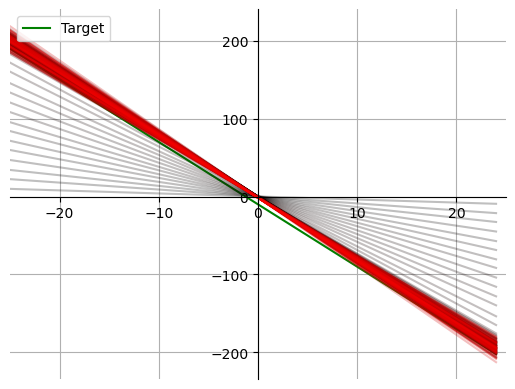

In [18]:
def run_experiment(a_true,b_true,snapshots,verbose,progress_bar,batch):

    opt = qml.GradientDescentOptimizer(learning_rate)
    weights = np.array([0.1,0.1],requires_grad=True,dtype=float)

    plots = []

    #Training...
    
    for e in tqdm(range(snapshots)) if progress_bar else range(snapshots):

        if verbose: print("***",colored("Snapshot "+str(e),"green"),"***")

        avg_cost = 0

        x = []
        y = []

        for fx in range(vec_len//2):
            x_i,y_i = gen_sample(a_true,b_true)#index=fx)

            x+=[x_i]
            y+=[y_i]

        x = np.array(x,dtype=float)
        y = np.array(y,dtype=float)

        ynorm = np.linalg.norm(y)

        y /= ynorm

        def cost(weights):

            ansatz = weights[0]*x + weights[1]
            ansatzNorm = np.linalg.norm(ansatz)
            ansatz = ansatz/ansatzNorm

            vec = np.concatenate((ansatz,y))/np.sqrt(2)

            output = prod_circuit(vec) #Expected Value of Q_0 = |0>

            inner_product = 2*output[0] - 1

            y_ansatz = ansatzNorm/ynorm * inner_product

            return abs(1-y_ansatz)

        avg = 0

        for b in range(batch): 

            weights, cst = opt.step_and_cost(cost, weights)
            avg += cst
            if verbose: print(" b =",b,"| Weights =",weights,"| Cost =",colored(str(cst),"yellow"))

        if verbose: print("AVG:",colored(str(avg/batch),"green"))

        if verbose: print("*"*len("*** "+"Snapshot "+str(e)+" ***"))

        plots+=[compute_plot(weights[0],weights[1])]

    return plots,a_true,b_true,weights

print(colored("Start Training!","blue"))
plots,a_true_i,b_true_i,weights = run_experiment(-8,-10,snapshots,verbose,True,batch)
print(colored("Finished Training!\n","blue"))
print("True Line:",colored("y = "+str(a_true_i)+"x + "+str(b_true_i),"green"))
print("Final Prediction:","y = ("+colored(str(weights[0]),"red")+")x + "+colored(str(weights[1]),"red"))
print("a_pred loss:",colored(str(abs(a_true-weights[0])),"red"),"| b_pred loss:",colored(str(abs(b_true-weights[1])),"red"))
show_plot(plots,a_true,b_true)


In an ideal model, the loss for both $a_{\text{pred}}$ and $b_{\text{pred}}$ would be minimal. 

As you may have noticed, in the above example, the loss for $a_{\text{pred}}$ is significantly less than our loss for $b_{\text{true}}$. This is believed to be caused by the fact that the $a_\text{true}$ component, in the equation $y ={a_\text{true}}*x + b_{\text{true}}$, has significantly more weight towards the value of $y$. 

As x increases, $a_{\text{true}}*x$ will grow, and $b_{\text{true}}$ will remain constant. Likewise, while x decreases, $a_{\text{true}}*x$ will also decrease, still with the weight of $b_{\text{true}}$ remaining constant. Also, it is important to note that when $\lvert x\lvert \approx 0$, 'b_true' will have the highest weight towards the value of 'y', and vice versa. 

As well, if we have a small $a_{\text{true}}$, as long as 'x' is in a feasible range, we will find that $b_{\text{true}}$ could have higher weight towards the value of y. The following experiment graphs the loss for 'b_pred' as we increase the magnitude of 'a_true'. 

Notice how this graph below resembles a vshape as $a_{\text{true}} \approx 0$, which follows in line with the discussion above, and therefore, supports the above claim.

Start Experiment!


  0%|          | 0/5 [00:00<?, ?it/s]

Finished Experiment!


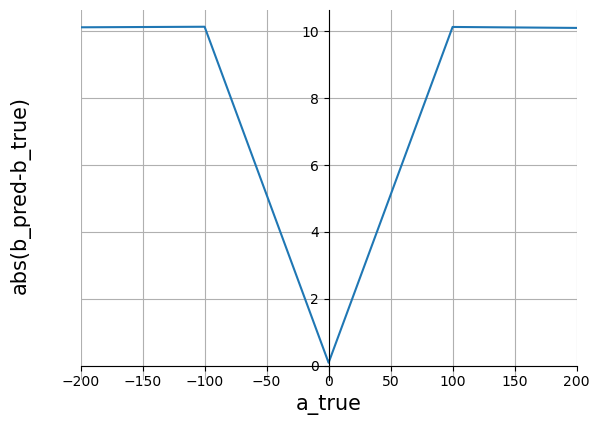

In [34]:
print(colored("Start Experiment!","blue"))
b_exp = -10
a_pred_loss = []
a_vals = np.linspace(-200,200,5)

for a_i in tqdm(a_vals):
    plots,a_true_i,b_true_i,weights = run_experiment(a_i,b_exp,100,verbose,False,8)
    a_pred_loss += [abs(b_true-weights[1])]
    
print(colored("Finished Experiment!","blue"))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position("left")
ax.yaxis.set_label_coords(-0.1, .5)

plt.plot(a_vals, a_pred_loss)
plt.xlabel('a_true', fontsize=15)
plt.ylabel('abs(b_pred-b_true)', fontsize=15)

plt.xlim(-200,200)
plt.grid(True)
plt.show()

$\textbf{References}$
- https://qiskit.org/textbook/ch-demos/variational-quantum-regression.html
- https://pennylane.ai/